<a href="https://colab.research.google.com/github/drbaijsingh/baijsingh/blob/main/copy_of_cmapss_fd003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import pandas as pd
import numpy as np

columns = (
    ['engine_id', 'cycle'] +
    [f'op_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)

train_df = pd.read_csv(
    '/content/train_FD003.txt',
    delim_whitespace=True,
    header=None,
    names=columns
)

train_df.head()


/tmp/ipython-input-3948750841.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(


,engine_id,cycle,op_1,op_2,op_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [ ]:
print("Shape:", train_df.shape)
print("Engines:", train_df.engine_id.nunique())


Shape: (24720, 26)
Engines: 100


In [ ]:
train_df[['engine_id','cycle']].tail()

,engine_id,cycle
24715,100,148
24716,100,149
24717,100,150
24718,100,151
24719,100,152


In [ ]:
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = train_df['engine_id'].map(max_cycle) - train_df['cycle']


In [ ]:
train_df.groupby('engine_id')['RUL'].agg(['min','max']).head()


,min,max
engine_id,,
1,0,258
2,0,252
3,0,221
4,0,271
5,0,212


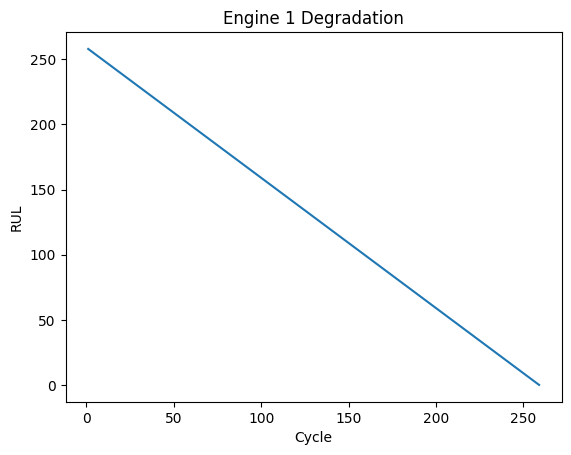

In [ ]:
import matplotlib.pyplot as plt

e1 = train_df[train_df.engine_id == 1]

plt.figure()
plt.plot(e1['cycle'], e1['RUL'])
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Engine 1 Degradation")
plt.show()


In [ ]:
train_df.drop(columns=['op_1','op_2','op_3'], inplace=True)


In [ ]:
features = [
    'sensor_2','sensor_3','sensor_4','sensor_7',
    'sensor_8','sensor_9','sensor_11','sensor_12',
    'sensor_13','sensor_14','sensor_15',
    'sensor_17','sensor_20','sensor_21'
]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])


In [ ]:
def create_sequences(df, seq_len, feature_cols):
    X, y = [], []

    for eid in df.engine_id.unique():
        edf = df[df.engine_id == eid].reset_index(drop=True)

        for i in range(len(edf) - seq_len):
            X.append(edf.loc[i:i+seq_len-1, feature_cols].values)
            y.append(edf.loc[i+seq_len, 'RUL'])

    return np.array(X), np.array(y)


In [ ]:
SEQ_LEN = 30
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

print(X_train.shape)
print(y_train.shape)

(21720, 30, 14)
(21720,)


In [ ]:
# Recompute RUL cleanly
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = max_cycle[train_df.engine_id].values - train_df.cycle

# Cap RUL
train_df['RUL'] = train_df['RUL'].clip(upper=125)

# Recreate sequences
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

In [ ]:
RUL_CAP = 125
train_df['RUL'] = train_df['RUL'].clip(upper=RUL_CAP)




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LEN, len(features))),
    Dropout(0.3),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)



Epoch 1/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 7968.6865 - mae: 79.4838 - val_loss: 6186.5078 - val_mae: 69.1325
Epoch 2/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5770.4248 - mae: 66.6472 - val_loss: 4684.2632 - val_mae: 60.0163
Epoch 3/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4390.6797 - mae: 58.2036 - val_loss: 3610.3806 - val_mae: 53.1235
Epoch 4/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3431.2271 - mae: 52.0158 - val_loss: 2863.5322 - val_mae: 47.9667
Epoch 5/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2737.2471 - mae: 47.1004 - val_loss: 2370.0212 - val_mae: 44.2144
Epoch 6/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2265.5559 - mae: 43.3278 - val_loss: 2063.0696 - val_mae: 41.5576
Epoch 7/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1992.0789 - mae: 40.8426 - val_loss: 1884.9418 - val_mae: 39.7193
Epoch 8/40
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1855.9261 - mae: 39.3950 - val_loss: 1793.2332 - val_mae

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


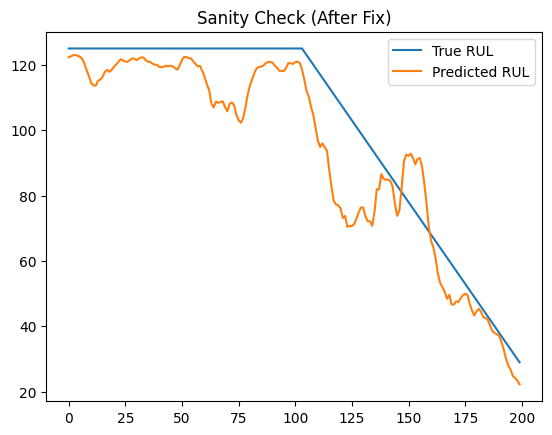

In [ ]:
pred = model.predict(X_train[:200])

plt.figure()
plt.plot(y_train[:200], label='True RUL')
plt.plot(pred.flatten(), label='Predicted RUL')
plt.legend()
plt.title("Sanity Check (After Fix)")
plt.show()

In [ ]:
print("Final Training MAE:", history.history['mae'][-1])
print("Final Validation MAE:", history.history['val_mae'][-1])
print("Final Training MSE:", history.history['loss'][-1])
print("Final Validation MSE:", history.history['val_loss'][-1])


Final Training MAE: 9.222553253173828
Final Validation MAE: 8.56756591796875
Final Training MSE: 184.17994689941406
Final Validation MSE: 164.91485595703125


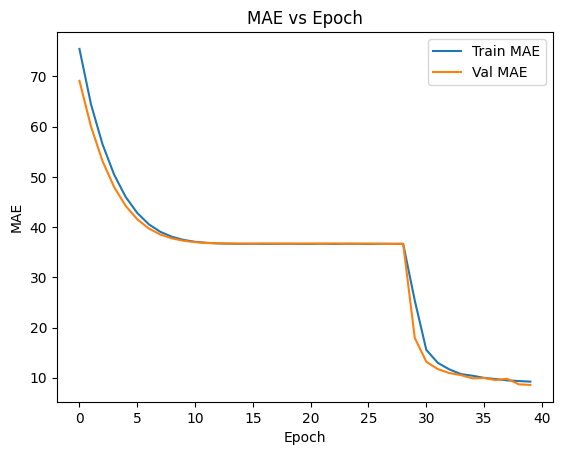

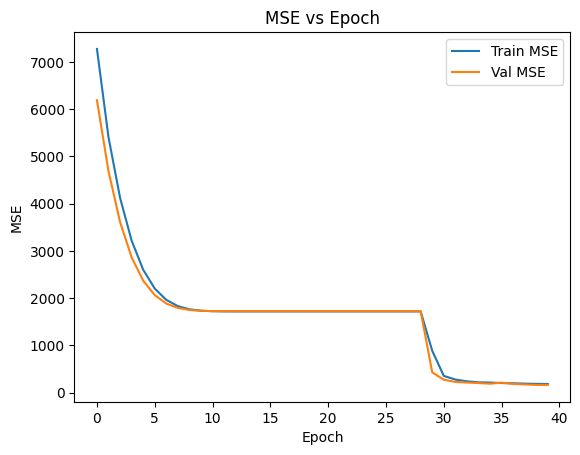

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Epoch')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Epoch')
plt.show()
